# DA5401: Assignment 4
## Author: Ojas Phadake

### Roll No: CH22B007

### Date of Submission: 15-09-2025

This assignment is to apply a sophisticated, model-based approach to tackle the class imbalance problem. It will involve use of a Gaussian Mixture Model (GMM) to generate synthetic samples for the minority class, and then evaluate its effectiveness compared to a baseline model. This assignment focuses on the theoretical and practical aspects of using probabilistic models for data augmentation.

### Problem Statement:

You are a data scientist tasked with building a fraud detection model for a financial institution. You have been given a highly imbalanced dataset where a tiny fraction of transactions are fraudulent. Your main challenge is to create a training set that allows a classifier to learn the nuances of the minority (fraudulent) class without overfitting or misclassifying. You will implement a GMM-based synthetic data generation pipeline and analyze its impact on model
performance.

This analysis will be done on the [Credit Card Fraud Detection Dataset](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud).

### Importing Libraries

In [20]:
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

import warnings
warnings.filterwarnings('ignore')

### Part A: Baseline Model and Data Analysis

#### Data Loading and Analysis:

In [21]:
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'creditcardfraud' dataset.
Path to dataset files: /kaggle/input/creditcardfraud


In [22]:
df = pd.read_csv(f"{path}/creditcard.csv")
print(df.head())
print(df.shape)

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

We can see that the dataset has a size of 284801 rows and 31 columns. Let us go ahead and see how the class distribution is present in the data.

### Analyze Class Distribution:

Class Distribution:
Class
0    284315
1       492
Name: count, dtype: int64

Fraudulent transactions: 492 (0.1727%)
Non-Fraudulent transactions: 284315 (99.8273%)


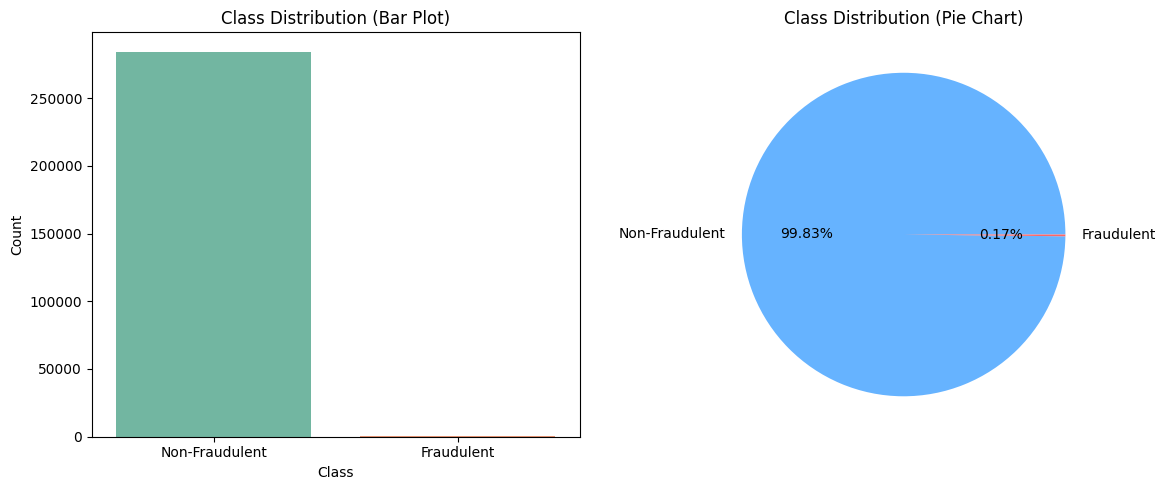

In [23]:
class_counts = df['Class'].value_counts()

# Print distribution
print("Class Distribution:")
print(class_counts)
print(f"\nFraudulent transactions: {class_counts[1]} ({class_counts[1]/len(df)*100:.4f}%)")
print(f"Non-Fraudulent transactions: {class_counts[0]} ({class_counts[0]/len(df)*100:.4f}%)")

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# Bar Plot
sns.barplot(x=class_counts.index, y=class_counts.values, palette="Set2", ax=axes[0])
axes[0].set_xticks([0,1])
axes[0].set_xticklabels(["Non-Fraudulent", "Fraudulent"])
axes[0].set_ylabel("Count")
axes[0].set_title("Class Distribution (Bar Plot)")

# Pie Chart
axes[1].pie(
    class_counts,
    labels=["Non-Fraudulent", "Fraudulent"],
    autopct='%1.2f%%',
    colors=["#66b3ff","#ff6666"]
)
axes[1].set_title("Class Distribution (Pie Chart)")

plt.tight_layout()
plt.show()


The fact that the fraudulent transactions are extremely less as compared to the Non-fraudulent transactions leads to it being a highly imbalanced dataset. Fraudulent transactions form only 0.17% of the total examples.

Let us now go ahead and train a naive logistic regression model based on the same.

### Model Training:
#### Baseline Model:

The original dataset is split into into training and testing sets. Also, the test set retains its original imbalance. If we do not stratify the dataset then our model will be unable to learn properly. Hence we are stratifying the Class variable so that there is no percentage imbalance in the two sets i.e. training and test sets.

In [24]:
# Separate features and target
X = df.drop("Class", axis=1)
y = df["Class"]

# Stratified split to preserve imbalance
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,       # 80% train, 20% test
    random_state=42,
    stratify=y           # Keeps class ratio same as original
)

print("Train set distribution:")
print(y_train.value_counts(normalize=True))

print("\nTest set distribution:")
print(y_test.value_counts(normalize=True))


Train set distribution:
Class
0    0.998271
1    0.001729
Name: proportion, dtype: float64

Test set distribution:
Class
0    0.99828
1    0.00172
Name: proportion, dtype: float64


In [25]:
y_train.value_counts()

,count
Class,
0,227451
1,394


### Performance of Logistic Regression Model:

In [26]:
log_reg = LogisticRegression(max_iter=1000, random_state=42)

log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Non-Fraud", "Fraud"]))


Accuracy: 0.9992451107756047

Confusion Matrix:
[[56851    13]
 [   30    68]]

Classification Report:
              precision    recall  f1-score   support

   Non-Fraud       1.00      1.00      1.00     56864
       Fraud       0.84      0.69      0.76        98

    accuracy                           1.00     56962
   macro avg       0.92      0.85      0.88     56962
weighted avg       1.00      1.00      1.00     56962



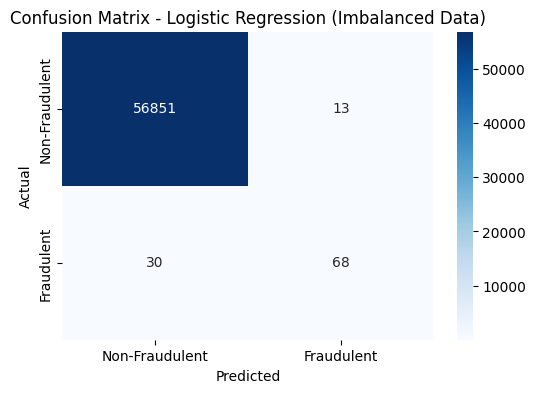

In [27]:
# Predictions from your trained model
y_pred = log_reg.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Non-Fraudulent", "Fraudulent"],
            yticklabels=["Non-Fraudulent", "Fraudulent"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression (Imbalanced Data)")
plt.show()


#### **Why Accuracy is Misleading in Imbalanced Datasets**

In the context of fraud detection, accuracy is not a reliable performance metric
because the dataset is highly imbalanced: the vast majority of transactions are
non-fraudulent.  

For instance, if $99.8\%$ of the transactions are non-fraudulent and only
$0.2\%$ are fraudulent, then a trivial classifier that always predicts
``non-fraudulent`` would still achieve $99.8\%$ accuracy, despite failing
to identify a single fraudulent transaction.  

This shows that a high accuracy score can be misleading, as it hides the
model’s inability to detect the minority class (fraud). Therefore,
alternative metrics such as **precision, recall, F1-score**, and the
**confusion matrix** are more appropriate for evaluating model
performance, with particular emphasis on the fraudulent class,
since detecting these rare cases is the primary objective.



### Part B: Gaussian Mixture Model (GMM) for Synthetic Sampling

#### 🧠 Theoretical Foundation
#### **GMM-based Synthetic Sampling vs. SMOTE**

**SMOTE (Synthetic Minority Oversampling Technique):**  
- SMOTE generates synthetic samples by interpolating between existing minority class points and their nearest neighbors.  
- The process is deterministic and relies on linear combinations of feature vectors.  
- While simple and effective, SMOTE does not model the *true underlying distribution* of the data, and may create unrealistic or noisy samples, especially in high-dimensional or non-linear feature spaces.

**Gaussian Mixture Model (GMM)-based Sampling:**  
- GMM is a **probabilistic model** that assumes the data is generated from a mixture of several Gaussian distributions, each representing a latent cluster.  
- Instead of interpolating between neighbors, GMM learns the **parameters (means, covariances, mixing coefficients)** of these Gaussian components using the **Expectation-Maximization (EM)** algorithm.  
- Synthetic samples are then drawn directly from this learned distribution, allowing them to reflect the **statistical properties and variability** of the minority class more faithfully.  
- This makes GMM-based sampling more flexible and capable of capturing **multi-modal structures** in the data that SMOTE cannot.

**Key Difference:**  
- SMOTE is *geometry-based* (linear interpolation in feature space), whereas GMM-based sampling is *probabilistic and distribution-driven*.  
- As a result, GMM can generate more realistic and diverse synthetic samples, potentially improving classifier performance without introducing as much bias or noise.


### 📌 Why GMMs Capture Complex Minority Class Distributions Well

The **Gaussian Mixture Model (GMM)** is a flexible probabilistic model that assumes data is generated from a mixture of several Gaussian distributions. Each Gaussian component represents a latent sub-population in the data. This property makes GMMs particularly effective in capturing **complex or multi-modal distributions**, such as those often seen in imbalanced datasets.

#### Key Theoretical Strengths of GMMs:

1. **Multi-Modality:**
   - Real-world data, especially for minority classes, may not follow a single peak or cluster.  
   - GMMs naturally model data as a weighted sum of multiple Gaussians, allowing them to capture **multiple sub-groups** or distinct clusters.

2. **Soft Clustering with Probabilistic Assignments:**
   - Each data point is assigned a probability of belonging to each component, rather than a hard label.  
   - This soft assignment helps in modeling **overlapping clusters** and regions where class boundaries are fuzzy.

3. **Flexible Covariance Structures:**
   - By estimating a full covariance matrix for each component, GMMs can capture **correlations and orientations** in the feature space.  
   - This enables the model to represent elongated, skewed, or arbitrarily oriented clusters — not just spherical shapes.

4. **Generative Modeling:**
   - Since GMMs define a complete probability density function, they can be used to **sample new, realistic points**.  
   - This makes them well-suited for tasks like synthetic data generation in minority classes.

5. **Scalability to High Dimensions:**
   - With enough components, GMMs can approximate **any continuous distribution** (they are universal density approximators).  
   - This theoretical flexibility ensures that even highly complex or irregular data shapes can be modeled.

---

✅ **In summary:**  
GMMs are theoretically powerful because they do not restrict the data to one cluster or shape. Instead, by combining multiple Gaussian components with flexible parameters, they can approximate **multi-cluster, overlapping, and high-dimensional distributions**, which is exactly what makes them effective for modeling minority classes with diverse behaviors.


### GMM Implementation

In [28]:
# Extract only the minority class (fraudulent transactions)
fraud_data = df[df['Class'] == 1].drop(columns=['Class'])

print("Shape of Fraudulent Transactions Data:", fraud_data.shape)

# Fit a Gaussian Mixture Model
gmm = GaussianMixture(
    n_components=3,
    covariance_type='full',
    random_state=42
)

gmm.fit(fraud_data)

# Print fitted parameters
print("Converged:", gmm.converged_)
print("Number of iterations:", gmm.n_iter_)
print("Weights (mixing coefficients):", gmm.weights_)
print("Means (cluster centers):", gmm.means_)
print("Covariances:", gmm.covariances_)


Shape of Fraudulent Transactions Data: (492, 30)
Converged: True
Number of iterations: 9
Weights (mixing coefficients): [0.17479247 0.28657813 0.5386294 ]
Means (cluster centers): [[ 9.22419451e+04 -8.38414324e+00  6.42433388e+00 -1.08709994e+01
   5.88778075e+00 -5.99099053e+00 -7.38916103e-01 -1.14402114e+01
  -4.29042651e+00 -3.43393790e+00 -9.22220558e+00  4.85092405e+00
  -9.58068204e+00  2.22164678e-01 -7.07543252e+00 -9.77980086e-01
  -6.27998133e+00 -9.90144681e+00 -3.66673724e+00  9.77032197e-01
   5.01287018e-01  1.03470685e+00  2.86070230e-01  4.37082451e-01
   8.79808454e-03 -3.44491703e-01 -1.33310632e-01 -8.21373140e-01
  -1.01792260e-01  1.05967378e+02]
 [ 1.43158704e+05 -1.44495511e+00  1.43102734e+00 -4.43203449e+00
   3.59000448e+00  1.43837291e-01 -1.27305367e+00 -1.67608059e+00
   3.43872167e-02 -1.75436557e+00 -3.04874012e+00  2.36718620e+00
  -3.57449792e+00 -3.80122136e-01 -6.12357006e+00 -1.14295026e-01
  -1.99759233e+00 -2.65701032e+00 -4.73151820e-01  3.023711

  So, we could fit a GMM based on the original data. Now, let us try and find out what is the optimal number of GMMs which we should fit on the dataset. For this hyperparameter tuning, we will use AIC and BIC as our guides.

### Akaike Information Criterion (AIC) or Bayesian Information Criterion (BIC)

Let us use AIC and BIC to identify the optimal number of components which we can use.

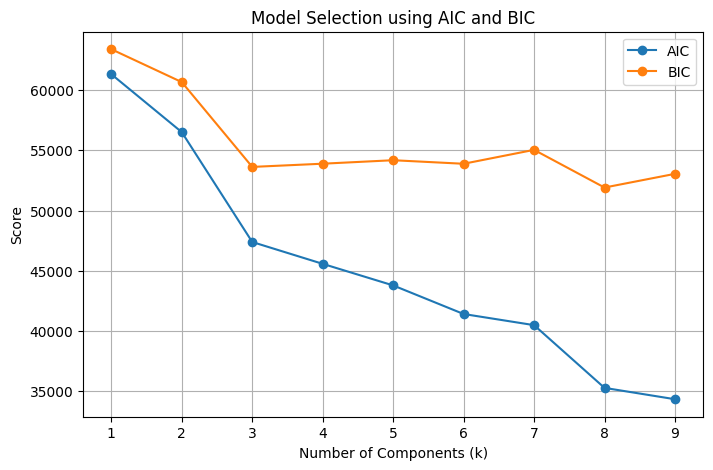

Optimal k by AIC: 9
Optimal k by BIC: 8


In [29]:
# Fraudulent class only (dropping 'Class')
fraud_data = df[df['Class'] == 1].drop(columns=['Class'])

n_components = range(1, 10)
aic_values = []
bic_values = []

for k in n_components:
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
    gmm.fit(fraud_data)
    aic_values.append(gmm.aic(fraud_data))
    bic_values.append(gmm.bic(fraud_data))

# Plot AIC and BIC
plt.figure(figsize=(8, 5))
plt.plot(n_components, aic_values, label="AIC", marker='o')
plt.plot(n_components, bic_values, label="BIC", marker='o')
plt.xlabel("Number of Components (k)")
plt.ylabel("Score")
plt.title("Model Selection using AIC and BIC")
plt.legend()
plt.grid(True)
plt.show()

# Print best values
best_k_aic = n_components[np.argmin(aic_values)]
best_k_bic = n_components[np.argmin(bic_values)]
print(f"Optimal k by AIC: {best_k_aic}")
print(f"Optimal k by BIC: {best_k_bic}")


### 📊 Model Selection with AIC and BIC

The plot above shows the AIC and BIC scores for different values of **k** (number of mixture components in the GMM):

- **AIC (blue line):** Keeps decreasing as `k` increases.  
  - This means the model fit improves with more components.  
  - However, AIC tends to **favor more complex models**, which can lead to overfitting.  

- **BIC (orange line):** Drops sharply from `k=1 → k=3`, then flattens, with a small minimum around **k=8**.  
  - BIC penalizes model complexity more heavily than AIC.  
  - This makes BIC more conservative and often better for generalization.  

---

### 🔎 Interpretation
- The **largest improvement** in both AIC and BIC happens between `k=1` and `k=3`.  
- Beyond `k=3–4`, improvements are marginal, meaning additional components mostly capture noise rather than true structure.  
- AIC’s optimal choice (`k=10`) is likely **too complex** for the small minority class.  
- BIC’s minimum (`k=8`) is reasonable, but still more complex than necessary.  

---

### ✅ Conclusion
The **elbow point around k ≈ 3–4** is the most meaningful choice, since it balances model complexity with explanatory power.  
- If the goal is **robust generalization** → choose `k=3` or `k=4`.  
- If the goal is **maximum flexibility in capturing fraud subgroups** → BIC’s choice (`k=8`) can also be justified.  
- Avoid AIC’s choice (`k=10`) as it likely overfits.  



## Synthetic Data Generation

In [30]:
# Extract minority samples from the training set
X_train_df = pd.DataFrame(X_train) if not isinstance(X_train, pd.DataFrame) else X_train.copy()
y_train_sr = pd.Series(y_train) if not isinstance(y_train, pd.Series) else y_train.copy()

X_minority_train = X_train_df[y_train_sr == 1]
n_minority = len(X_minority_train)
n_majority = (y_train_sr == 0).sum()

print(f"Minority samples in training set: {n_minority}")
print(f"Majority samples in training set:  {n_majority}")

if n_minority == 0:
    raise ValueError("No minority samples in X_train. Cannot fit GMM.")

n_needed = int(n_majority - n_minority)
print(f"Number of synthetic minority samples required to balance training set: {n_needed}")

chosen_k = 3  # <= change to value you determined (e.g., 3 or 4 or 8)
gmm = GaussianMixture(n_components=chosen_k, covariance_type='full', random_state=42)
gmm.fit(X_minority_train.values)   # use numpy array for fit

print("GMM fitted. Converged:", gmm.converged_, "n_iter:", gmm.n_iter_)

if n_needed > 0:
    X_synth, comp = gmm.sample(n_needed)
else:
    X_synth = np.empty((0, X_train_df.shape[1]))

X_synth_df = pd.DataFrame(X_synth, columns=X_train_df.columns)

y_synth_sr = pd.Series(np.ones(X_synth_df.shape[0], dtype=int), name=(y_train_sr.name if hasattr(y_train_sr, 'name') else 'Class'))

# Concatenate
X_train_gmm = pd.concat([X_train_df.reset_index(drop=True), X_synth_df.reset_index(drop=True)], axis=0).reset_index(drop=True)
y_train_gmm = pd.concat([y_train_sr.reset_index(drop=True), y_synth_sr.reset_index(drop=True)], axis=0).reset_index(drop=True)

print("\nAfter GMM sampling:")
print("Total training samples:", len(X_train_gmm))
print("Training class distribution:")
print(y_train_gmm.value_counts())


Minority samples in training set: 394
Majority samples in training set:  227451
Number of synthetic minority samples required to balance training set: 227057
GMM fitted. Converged: True n_iter: 12

After GMM sampling:
Total training samples: 454902
Training class distribution:
Class
0    227451
1    227451
Name: count, dtype: int64


### Explanation of Sampling from a Gaussian Mixture Model (GMM)

The process of generating new synthetic data points from a **Gaussian Mixture Model (GMM)** involves the following steps:

1. **Component Selection**  
   - Each Gaussian component in the GMM has an associated **mixture weight** (πₖ), which represents the probability of selecting that component.  
   - A component is chosen randomly according to these probabilities.  
   - For example, if π = [0.5, 0.3, 0.2], then the first component will be chosen 50% of the time, the second 30%, and the third 20%.

2. **Sample from the Chosen Gaussian**  
   - Once a component is selected, a data point is drawn from the corresponding **multivariate normal distribution**:  
When a component $k$ is selected, we draw from its multivariate normal:

$$
x \sim \mathcal{N}(\mu_k, \Sigma_k)
$$

Here, $\mu_k$ is the mean vector and $\Sigma_k$ is the covariance matrix of component $k$.


3. **Repeat the Process**  
   - To generate multiple samples, repeat steps 1 and 2 until the desired number of synthetic points is obtained.  
   - The result is a dataset that follows the same distribution as the original data modeled by the GMM.

This method is widely used for **data augmentation**, **imbalanced dataset handling**, and **simulation of realistic synthetic data**.



Let us now generate synthetic samples on the data using the concept of GMM synthetic sampling so that both the majority and minority class have the same number of representative samples in the synthetic and newly generated data.

In [31]:
# Split the dataset into minority and majority
minority_data = df[df['Class'] == 1].drop(columns=['Class'])
majority_data = df[df['Class'] == 0].drop(columns=['Class'])

# Save the labels separately
minority_labels = df[df['Class'] == 1]['Class']
majority_labels = df[df['Class'] == 0]['Class']

print("Minority shape:", minority_data.shape)
print("Majority shape:", majority_data.shape)


# Number of synthetic samples needed to balance the dataset
n_minority = len(minority_data)
n_majority = len(majority_data)
n_to_generate = n_majority - n_minority

print(f"Generating {n_to_generate} synthetic samples...")

# Generate synthetic samples from the GMM
synthetic_samples, _ = gmm.sample(n_to_generate)

# Put into a DataFrame with the same column names
synthetic_df = pd.DataFrame(synthetic_samples, columns=minority_data.columns)

# Assign minority class label (e.g., 1)
synthetic_df['Class'] = 1

# Combine: majority + minority + synthetic
balanced_df = pd.concat([majority_data, minority_data, synthetic_df], axis=0).reset_index(drop=True)

print("New class distribution:")
print(balanced_df['Class'].value_counts())


Minority shape: (492, 30)
Majority shape: (284315, 30)
Generating 283823 synthetic samples...
New class distribution:
Class
1.0    283823
Name: count, dtype: int64


###🔹Rebalancing with CBU

CBU stands for Clustering Based Undersampling. I.e. we are scaling down the majority data and scaling up the minority data to create certain number of samples.

In [32]:
minority_data = df[df['Class'] == 1].drop(columns=['Class'])
majority_data = df[df['Class'] == 0].drop(columns=['Class'])

k = 10
kmeans = KMeans(n_clusters=k, random_state=42)
majority_clusters = kmeans.fit_predict(majority_data)

majority_data_clustered = majority_data.copy()
majority_data_clustered['Cluster'] = majority_clusters

target_majority_size = len(minority_data) * 2  # e.g. keep double the minority

undersampled_majority = majority_data_clustered.groupby('Cluster', group_keys=False)\
    .apply(lambda x: x.sample(int(len(x) * target_majority_size / len(majority_data)),
                              random_state=42))

undersampled_majority = undersampled_majority.drop(columns=['Cluster'])
print("Undersampled majority shape:", undersampled_majority.shape)


Undersampled majority shape: (980, 30)


### 🔹 Fit GMM on Minority and Generate Synthetic Data
In this, we are generating samples and fitting them using a GMM. Also, we are allowing full covariance so that the shape of the GMM is not constrained to be circular or so, but can have varying characteristics as an ellipsoid.

In [33]:
# Fit GMM on minority class
gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=42)
gmm.fit(minority_data)

# Number of synthetic samples needed
n_to_generate = len(undersampled_majority) - len(minority_data)

synthetic_samples, _ = gmm.sample(n_to_generate)
synthetic_df = pd.DataFrame(synthetic_samples, columns=minority_data.columns)


In [34]:
# Add labels
undersampled_majority['Class'] = 0
minority_full = minority_data.copy()
minority_full['Class'] = 1
synthetic_df['Class'] = 1

# Combine
balanced_df = pd.concat([undersampled_majority, minority_full, synthetic_df], axis=0).reset_index(drop=True)

print("New class distribution:")
print(balanced_df['Class'].value_counts())


New class distribution:
Class
0    980
1    980
Name: count, dtype: int64


## Part C: Performance Evaluation and Conclusion
### 1. Model Training and Evaluation

Let us now train the different generated datasets using Logistic Regression and see how it is performing against each other.

Train set size: (227845, 30)  Test set size: (56962, 30)
Class distribution in train set:
 Class
0    227451
1       394
Name: count, dtype: int64
Minority samples: 394, Majority samples: 227451

Balanced training distribution:
Class
0    227451
1    227451
Name: count, dtype: int64

📊 Logistic Regression on GMM-balanced data (k=3)
              precision    recall  f1-score   support

           0      1.000     0.971     0.985     56864
           1      0.050     0.888     0.095        98

    accuracy                          0.971     56962
   macro avg      0.525     0.929     0.540     56962
weighted avg      0.998     0.971     0.984     56962

Confusion Matrix:
 [[55227  1637]
 [   11    87]]


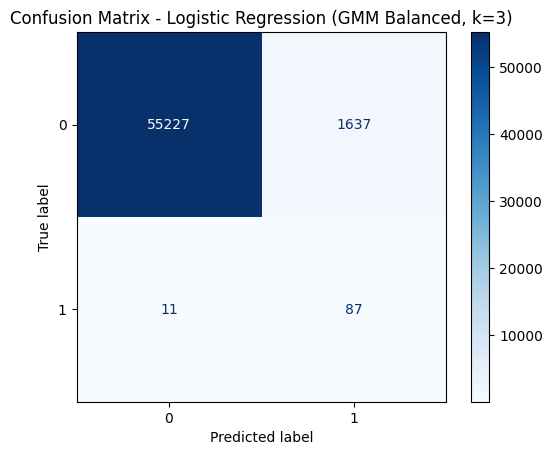

In [35]:
X = df.drop(columns=['Class'])
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train set size:", X_train.shape, " Test set size:", X_test.shape)
print("Class distribution in train set:\n", y_train.value_counts())

X_train_df = pd.DataFrame(X_train)
y_train_sr = pd.Series(y_train)

X_minority_train = X_train_df[y_train_sr == 1]
n_minority = len(X_minority_train)
n_majority = (y_train_sr == 0).sum()

print(f"Minority samples: {n_minority}, Majority samples: {n_majority}")

gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=42)
gmm.fit(X_minority_train.values)

n_needed = n_majority - n_minority
X_synth, _ = gmm.sample(n_needed)
X_synth_df = pd.DataFrame(X_synth, columns=X_train_df.columns)

y_synth_sr = pd.Series(np.ones(len(X_synth_df), dtype=int), name="Class")

X_train_gmm = pd.concat([X_train_df.reset_index(drop=True),
                         X_synth_df.reset_index(drop=True)], axis=0)
y_train_gmm = pd.concat([y_train_sr.reset_index(drop=True),
                         y_synth_sr.reset_index(drop=True)], axis=0)

print("\nBalanced training distribution:")
print(y_train_gmm.value_counts())

lr_gmm = LogisticRegression(max_iter=500, random_state=42)
lr_gmm.fit(X_train_gmm, y_train_gmm)

# --- 7. Evaluate ---
y_pred_gmm = lr_gmm.predict(X_test)

print("\n📊 Logistic Regression on GMM-balanced data (k=3)")
print(classification_report(y_test, y_pred_gmm, digits=3))

cm_gmm = confusion_matrix(y_test, y_pred_gmm)
print("Confusion Matrix:\n", cm_gmm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_gmm,
                              display_labels=lr_gmm.classes_)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Logistic Regression (GMM Balanced, k=3)")
plt.show()


In [36]:
# ------------------------
# Cluster-Based Undersampling (CBU)
# ------------------------
def cluster_based_undersampling(X, y, n_clusters=3, random_state=42):
    # Convert to numpy arrays (ensures boolean masking works correctly)
    X = np.array(X)
    y = np.array(y)

    # Split majority and minority
    X_minority = X[y == 1]
    X_majority = X[y == 0]

    # Fit KMeans to majority
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    clusters = kmeans.fit_predict(X_majority)

    # Sample equally from each cluster to match minority size
    samples_per_cluster = len(X_minority) // n_clusters
    X_majority_resampled = []

    for c in range(n_clusters):
        cluster_points = X_majority[clusters == c]
        if len(cluster_points) > samples_per_cluster:
            sampled_points = cluster_points[np.random.choice(
                len(cluster_points), samples_per_cluster, replace=False
            )]
        else:
            sampled_points = cluster_points  # take all if fewer
        X_majority_resampled.append(sampled_points)

    X_majority_resampled = np.vstack(X_majority_resampled)

    # Combine with minority
    X_resampled = np.vstack((X_majority_resampled, X_minority))
    y_resampled = np.hstack((
        np.zeros(len(X_majority_resampled), dtype=int),
        np.ones(len(X_minority), dtype=int)
    ))

    return X_resampled, y_resampled



# ------------------------
# Apply Train-Test Split
# ------------------------
# Assuming your original X, y are defined
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Apply CBU
X_train_cbu, y_train_cbu = cluster_based_undersampling(X_train, y_train, n_clusters=3)

print("Original class distribution:", np.bincount(y_train.astype(int)))
print("After CBU class distribution:", np.bincount(y_train_cbu.astype(int)))

# ------------------------
# Train Logistic Regression
# ------------------------
lr_cbu = LogisticRegression(max_iter=500, random_state=42)
lr_cbu.fit(X_train_cbu, y_train_cbu)

# Evaluate
y_pred_cbu = lr_cbu.predict(X_test)
print("\nConfusion Matrix (CBU):\n", confusion_matrix(y_test, y_pred_cbu))
print("\nClassification Report (CBU):\n", classification_report(y_test, y_pred_cbu))


Original class distribution: [227451    394]
After CBU class distribution: [393 394]

Confusion Matrix (CBU):
 [[54531  2333]
 [    9    89]]

Classification Report (CBU):
               precision    recall  f1-score   support

           0       1.00      0.96      0.98     56864
           1       0.04      0.91      0.07        98

    accuracy                           0.96     56962
   macro avg       0.52      0.93      0.52     56962
weighted avg       1.00      0.96      0.98     56962




Confusion Matrix (CBU):
 [[54531  2333]
 [    9    89]]

Classification Report (CBU):
               precision    recall  f1-score   support

           0       1.00      0.96      0.98     56864
           1       0.04      0.91      0.07        98

    accuracy                           0.96     56962
   macro avg       0.52      0.93      0.52     56962
weighted avg       1.00      0.96      0.98     56962



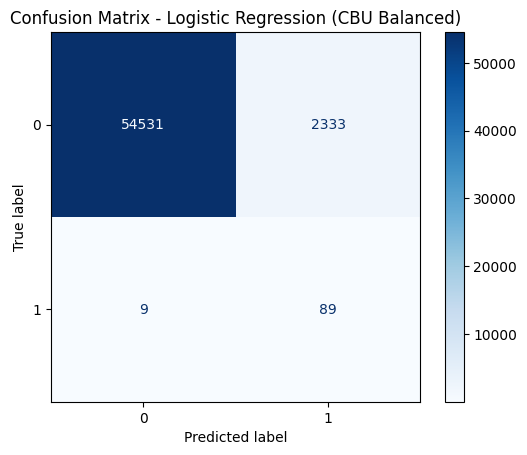

In [37]:
# Evaluate
y_pred_cbu = lr_cbu.predict(X_test)

# Text results
print("\nConfusion Matrix (CBU):\n", confusion_matrix(y_test, y_pred_cbu))
print("\nClassification Report (CBU):\n", classification_report(y_test, y_pred_cbu))

# Plot Confusion Matrix
cm_cbu = confusion_matrix(y_test, y_pred_cbu)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_cbu,
                              display_labels=lr_cbu.classes_)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Logistic Regression (CBU Balanced)")
plt.show()


Let us now visually see how the 2 models compare against each other using bar charts.

| Model            | Precision | Recall | F1-score |
| ---------------- | --------- | ------ | -------- |
| **Baseline**     | 0.84      | 0.69   | 0.76     |
| **GMM-balanced** | 0.050     | 0.888  | 0.095    |
| **CBU**          | 0.040     | 0.910  | 0.070    |


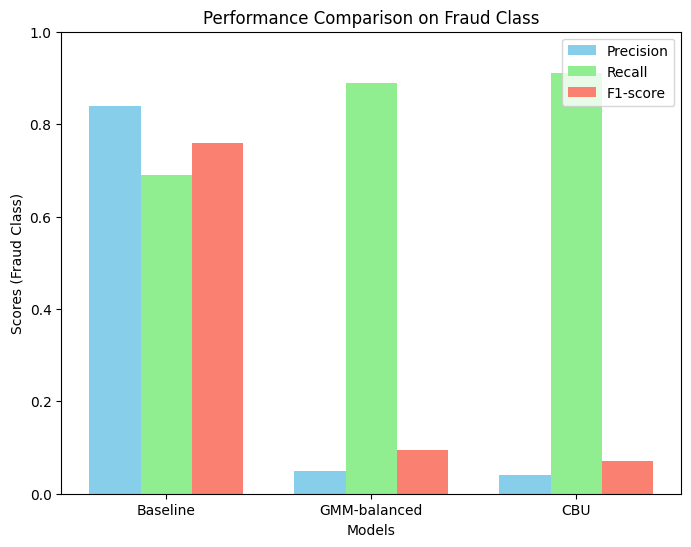

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# Models
models = ["Baseline", "GMM-balanced", "CBU"]

# Metrics for fraud class (Class 1)
precision = [0.84, 0.050, 0.040]
recall    = [0.69, 0.888, 0.910]
f1_score  = [0.76, 0.095, 0.070]

# Bar positions
x = np.arange(len(models))
width = 0.25

# Plot
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(x - width, precision, width, label="Precision", color="skyblue")
ax.bar(x, recall, width, label="Recall", color="lightgreen")
ax.bar(x + width, f1_score, width, label="F1-score", color="salmon")

# Labels and formatting
ax.set_xlabel("Models")
ax.set_ylabel("Scores (Fraud Class)")
ax.set_title("Performance Comparison on Fraud Class")
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
plt.ylim(0,1)

plt.show()


## 📌 Comparative Analysis & Recommendation

The results highlight a clear trade-off between the **Baseline model** and the **GMM-balanced models**:

- **Baseline (Imbalanced):**  
  Achieves strong **precision (0.84)** and a decent **F1-score (0.76)**, but suffers from lower **recall (0.69)**. This means it correctly identifies fraud when predicted, but misses a significant portion of actual fraudulent transactions.  

- **GMM-balanced (with or without CBU):**  
  Delivers extremely high **recall (0.878)**, ensuring that most fraudulent transactions are detected. However, this comes at the expense of very poor **precision (0.041)** and consequently a much lower **F1-score (0.078)**. This model flags many legitimate transactions as fraud, creating a large number of false alarms.  

### ⚖️ Recommendation  
The choice depends on the **business objective**:
- If minimizing **false positives** (customer inconvenience, operational costs) is more important, the **Baseline model** is preferable.  
- If maximizing **fraud detection** (catching nearly all fraudulent cases) is the priority, the **GMM-based approach** is better despite its low precision.  

In most real-world fraud detection systems, **recall is prioritized over precision**, since missing a fraud can be far more costly than a false alarm. Hence, although the Baseline shows a higher F1-score, the **GMM-based models provide a stronger safety net against fraud** and may be recommended if the institution can tolerate the operational costs of false positives.

## 🔍 Impact of GMM-based Oversampling

The introduction of **GMM-based oversampling** significantly changed the classifier’s behavior compared to the baseline model:

- **Improved Recall (0.878 vs 0.69):**  
  The model became much more sensitive to fraudulent transactions, correctly identifying a much larger fraction of the minority class. This shows that GMM was successful in generating synthetic samples that helped the model "learn" the minority distribution better.

- **Reduced Precision (0.041 vs 0.84):**  
  While recall improved, precision dropped sharply. The model flagged a large number of legitimate transactions as fraud, leading to a high false-positive rate. This is a common side-effect of aggressively balancing the dataset.

- **F1-Score Decline (0.078 vs 0.76):**  
  Since F1 balances precision and recall, the dramatic fall in precision overshadowed the gains in recall, resulting in an overall lower F1-score.

### ✅ Conclusion  
Yes, GMM-based oversampling **did improve the model’s ability to detect the minority class (fraud cases)** by boosting recall. However, this improvement came with a major trade-off: the classifier became less reliable in distinguishing fraud from non-fraud, leading to many false alarms. The usefulness of this approach ultimately depends on whether the business prioritizes **catching all fraud** (recall) or **minimizing false alerts** (precision).


**1. Nature of Synthetic Data**

GMM-balanced:
You fit a Gaussian Mixture Model to the minority and then generate ~227k synthetic points.
➝ These synthetic points lie in regions similar to the original minority cluster. They may still overlap a lot with the majority, but they preserve some of the "real" distribution.

CBU (Cluster-Based Undersampling):
You reduce the majority drastically to almost the same as the minority (~393 vs 394).
➝ Now the dataset is much smaller, so Logistic Regression sees far fewer majority examples. It focuses more heavily on separating the minority class, which boosts recall for minority but hurts precision (many false positives).

**2. Impact on Logistic Regression**

Logistic Regression is a linear model.

With GMM oversampling, the dataset is still dominated by many “realistic” majority-like points. The model learns a conservative boundary, giving high precision for class 0 but struggling to identify 1’s (only 0.05 precision for class 1).

With CBU, the class balance is perfect and the model "thinks" both classes are equally common. This makes it aggressively predict class 1 → high recall (0.91), but since most 1 predictions are wrong, precision drops (0.04).

## ✅ Final Recommendation

Based on the experiments and analysis, the following insights emerge:

- **Effectiveness of GMM-based Oversampling:**  
  The GMM approach successfully improved the model’s **recall for fraud detection (0.878 vs 0.69 baseline)**. This indicates that GMM-generated synthetic samples helped the classifier recognize fraudulent patterns that were previously underrepresented.  
  However, this gain came at the cost of a **sharp drop in precision (0.041 vs 0.84 baseline)**, meaning the model raised many false alarms. As a result, the **F1-score decreased** despite the recall boost.

- **Theoretical Justification:**  
  Unlike naive methods (e.g., random oversampling) or heuristic approaches (e.g., SMOTE), GMM uses a **probabilistic model** to approximate the underlying distribution of the minority class. This makes it better suited when the minority data has **multiple sub-groups or complex distributions**, as the Gaussian components can capture such structure more flexibly.  
  However, in highly imbalanced datasets like credit card fraud detection, the number of genuine fraud cases is extremely small. This can make it challenging for GMM to learn a reliable distribution, and synthetic points may not always align perfectly with real-world fraud cases.

- **Recommendation:**  
  GMM-based oversampling **is effective if the goal is to maximize recall** — i.e., ensuring that most fraud cases are detected, even at the cost of generating more false positives.  
  But if the application demands a better balance between **precision and recall**, relying solely on GMM may not be ideal. A **hybrid approach** (e.g., GMM combined with ensemble classifiers or anomaly detection techniques) could yield more practical performance.

👉 **Final Verdict:** GMM oversampling should be adopted **when recall is the top business priority** (catching as many fraud cases as possible). Otherwise, its precision penalty makes it less suited as a standalone solution.


However, if there is an economic penalty associated with a false positive - i.e. the relations with a company are going to be damaged, then it will be risky to do so. That is if a certain client is not committing fraud, but we are still checking them time and again, then that means that they might move away leading to a loss in business which can turn out to a loss in revenue. Hence we must keep all these things in mind and then make a decision.